C:\Users\janik\AppData\Local\Temp\ipykernel_25828\1650965184.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = mstats.winsorize(X[col], limits=[0.01, 0.01])


Model Performansları ( 'pot' değişkeni silindikten sonra ):

Lojistik Regresyon (Wins):
  Doğruluk: 0.9875
  Kesinlik: 0.9804
  Duyarlılık: 1.0000
  F1 Skoru: 0.9901
  AUC: 0.9773
  Karışıklık Matrisi:
[[29  1]
 [ 0 50]]

Rastgele Ormanlar:
  Doğruluk: 0.9750
  Kesinlik: 0.9615
  Duyarlılık: 1.0000
  F1 Skoru: 0.9804
  AUC: 0.9727
  Karışıklık Matrisi:
[[28  2]
 [ 0 50]]

KNN:
  Doğruluk: 0.9750
  Kesinlik: 0.9800
  Duyarlılık: 0.9800
  F1 Skoru: 0.9800
  AUC: 0.9820
  Karışıklık Matrisi:
[[29  1]
 [ 1 49]]

SVM:
  Doğruluk: 0.9875
  Kesinlik: 0.9804
  Duyarlılık: 1.0000
  F1 Skoru: 0.9901
  AUC: 0.9760
  Karışıklık Matrisi:
[[29  1]
 [ 0 50]]


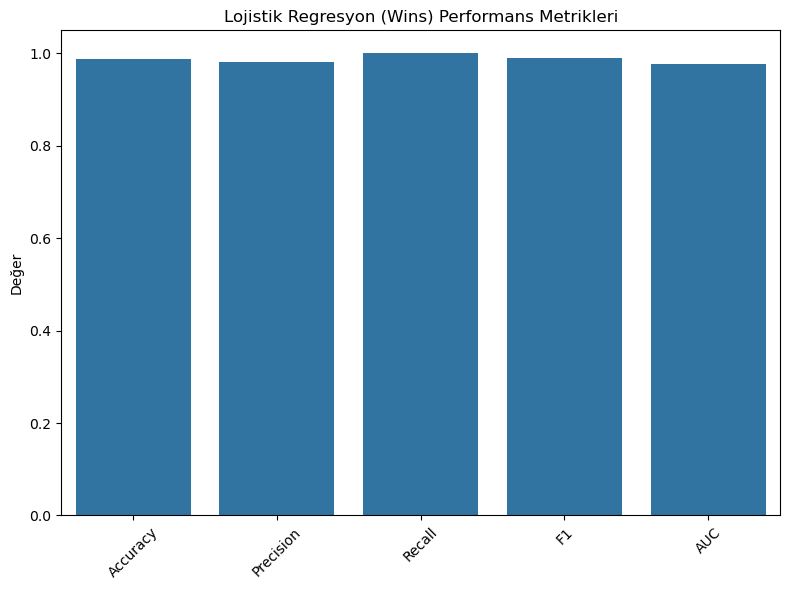

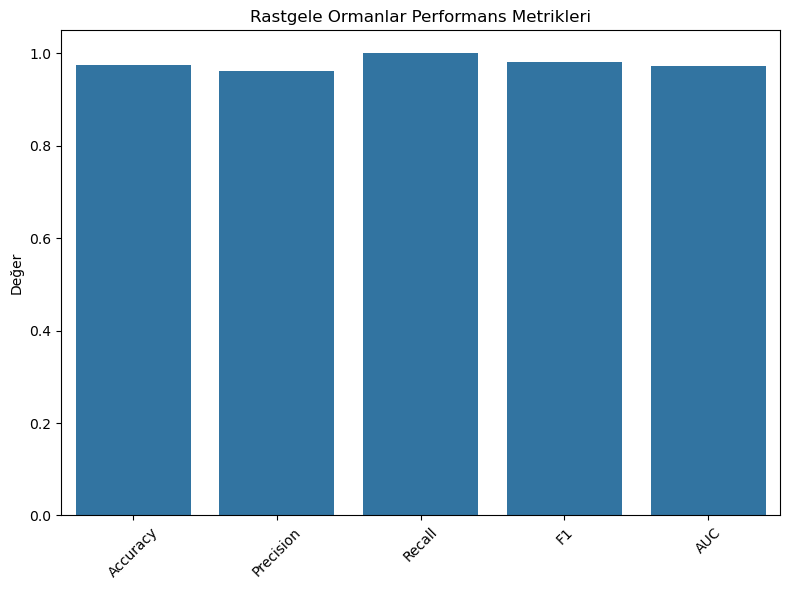

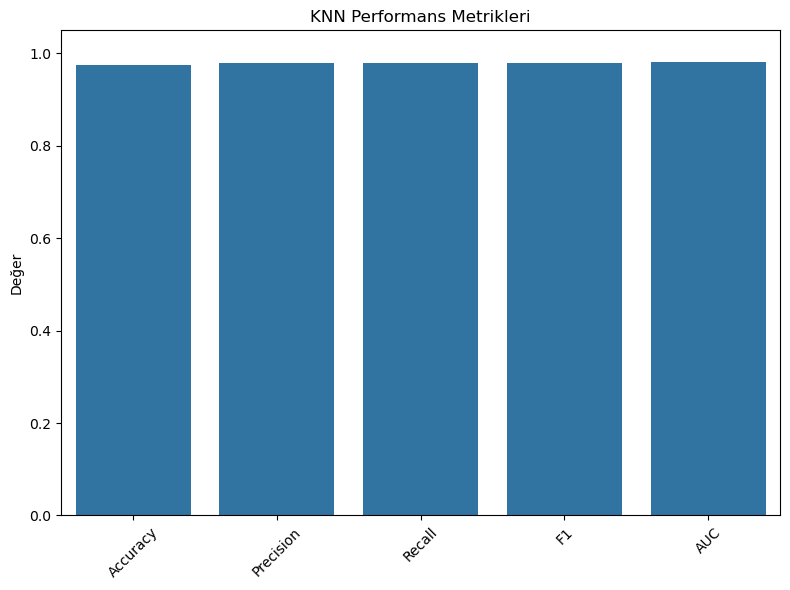

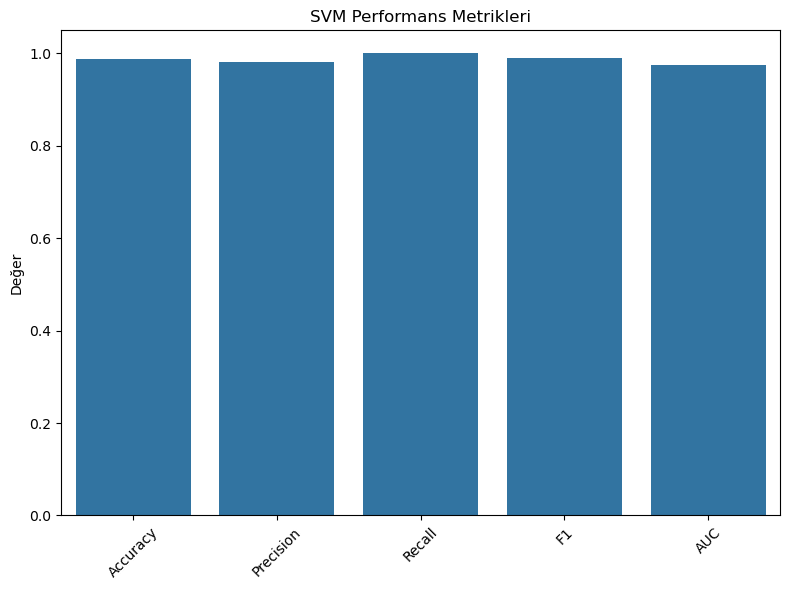

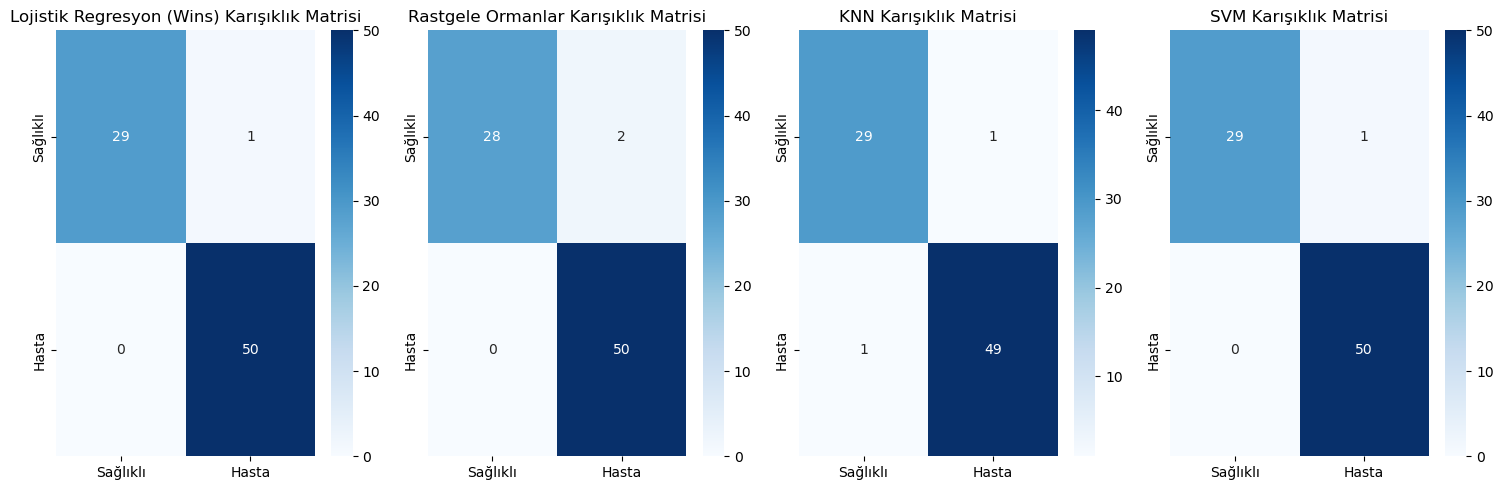

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Veri Setini Yükleme
chronic_kidney_disease = fetch_ucirepo(id=336)
X = chronic_kidney_disease.data.features
y = chronic_kidney_disease.data.targets

# 2. Eksik Değerleri Doldurma
# Sayısal sütunlardaki eksik değerleri medyan ile doldurma
for col in X.select_dtypes(include=['float64']).columns:
    X.loc[:, col] = X[col].fillna(X[col].median())

# Kategorik sütunlardaki eksik değerleri mod ile doldurma
for col in X.select_dtypes(include=['object']).columns:
    X.loc[:, col] = X[col].fillna(X[col].mode()[0])

# 3. Aykırı Değerleri Sınırlandırma (Winsorizing)
numerical_cols = X.select_dtypes(include=['float64']).columns
cols_to_winsorize = numerical_cols.tolist()

for col in cols_to_winsorize:
    X[col] = mstats.winsorize(X[col], limits=[0.01, 0.01])

# 4. Kategorik Değişkenleri Sayısallaştırma (One-Hot Encoding)
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 5. Hedef Değişkenini Sayısallaştırma
y_encoded = y['class'].apply(lambda x: 1 if x == 'ckd' else 0)

# 6. 'pot' değişkenini silme
X_encoded = X_encoded.drop(columns=['pot'])

# 7. Veri Setini Eğitim ve Test Kümelerine Ayırma
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 8. Veriyi Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 9. Model Eğitimi ve Değerlendirme Fonksiyonu
def evaluate_model(y_true, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1, "AUC": auc, "Confusion Matrix": cm}

model_evaluations = []

# 10. Lojistik Regresyon (Aykırı Değerler Sınırlandırılmış Veri ile)
logreg_model_winsorized = LogisticRegression(random_state=42, max_iter=1000)
logreg_model_winsorized.fit(X_train_scaled, y_train)
y_pred_logreg_winsorized = logreg_model_winsorized.predict(X_test_scaled)
y_prob_logreg_winsorized = logreg_model_winsorized.predict_proba(X_test_scaled)[:, 1]
model_evaluations.append(evaluate_model(y_test, y_pred_logreg_winsorized, y_prob_logreg_winsorized, "Lojistik Regresyon (Wins)"))

# 11. Rastgele Ormanlar
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
model_evaluations.append(evaluate_model(y_test, y_pred_rf, y_prob_rf, "Rastgele Ormanlar"))

# 12. K-En Yakın Komşu (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]
model_evaluations.append(evaluate_model(y_test, y_pred_knn, y_prob_knn, "KNN"))

# 13. Destek Vektör Makineleri (SVM)
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
model_evaluations.append(evaluate_model(y_test, y_pred_svm, y_prob_svm, "SVM"))

# 14. Performans Metriklerini Yazdırma
print("Model Performansları ( 'pot' değişkeni silindikten sonra ):")
for eval_result in model_evaluations:
    print(f"\n{eval_result['Model']}:")
    print(f"  Doğruluk: {eval_result['Accuracy']:.4f}")
    print(f"  Kesinlik: {eval_result['Precision']:.4f}")
    print(f"  Duyarlılık: {eval_result['Recall']:.4f}")
    print(f"  F1 Skoru: {eval_result['F1']:.4f}")
    print(f"  AUC: {eval_result['AUC']:.4f}")
    print(f"  Karışıklık Matrisi:\n{eval_result['Confusion Matrix']}")

# 15. Grafiksel Çıktılar (Her model için ayrı ayrı)
metric_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
for i, eval_result in enumerate(model_evaluations):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=metric_names, y=[eval_result[metric] for metric in metric_names])
    plt.title(eval_result['Model'] + " Performans Metrikleri")
    plt.ylim(0, 1.05)
    plt.ylabel("Değer")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 16. Karışıklık Matrislerini Tek Bir Görselde
fig, axes = plt.subplots(1, len(model_evaluations), figsize=(15, 5))
for i, eval_result in enumerate(model_evaluations):
    sns.heatmap(eval_result["Confusion Matrix"], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Sağlıklı', 'Hasta'], yticklabels=['Sağlıklı', 'Hasta'], ax=axes[i])
    axes[i].set_title(f"{eval_result['Model']} Karışıklık Matrisi")
plt.tight_layout()
plt.show()